In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import torch as t
import einops
from typing import Dict, List
import torch.sparse as sparse
from tqdm import tqdm
import gc
import torch as t
import torch.sparse as sparse
import einops
from tqdm import tqdm
import pickle
from typing import Dict, List
from pathlib import Path

from trainers.scae import SCAESuite
from buffer import AllActivationBuffer
from utils import load_model_with_folded_ln2, load_iterable_dataset
from find_top_connections import get_importance_scores
from trainers.top_k import AutoEncoderTopK
from trainers.scae import SCAESuite, TrainerSCAESuite, TrainerConfig

DTYPE = t.bfloat16
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
t.manual_seed(42)
t.set_grad_enabled(True)
gc.collect()

0

In [2]:
model = load_model_with_folded_ln2("gpt2", device=device, torch_dtype=DTYPE)
data = load_iterable_dataset('Skylion007/openwebtext')
suite = SCAESuite.from_pretrained(
    'jacobcd52/gpt2_suite_folded_ln',
    device=device,
    dtype=DTYPE,
    )

initial_submodule = model.transformer.h[0]
layernorm_submodules = {}
submodules = {}
for layer in range(model.config.n_layer):
    submodules[f"mlp_{layer}"] = (model.transformer.h[layer].mlp, "in_and_out")
    submodules[f"attn_{layer}"] = (model.transformer.h[layer].attn, "out")

    layernorm_submodules[f"mlp_{layer}"] = model.transformer.h[layer].ln_2

/root/dictionary_learning/notebooks/../trainers/scae.py:955: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = t.load(checkpoint_path, map_location='cpu')


In [3]:
import gc
gc.collect()
t.cuda.empty_cache()
buffer = AllActivationBuffer(
    data=data,
    model=model,
    submodules=submodules,
    initial_submodule=initial_submodule,
    layernorm_submodules=layernorm_submodules,
    d_submodule=model.config.n_embd,
    n_ctxs=128,
    out_batch_size = 32,
    refresh_batch_size = 128,
    device=device,
    dtype=DTYPE,
)

/root/dictionary_learning/notebooks/../buffer.py:237: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  t.cuda.amp.autocast(dtype=self.dtype)
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [4]:
with open("/root/dictionary_learning/connections_100.pkl", "rb") as f:
    suite.connections = pickle.load(f)

In [3]:
with open("/root/dictionary_learning/connections_100.pkl", "rb") as f:
    conn = pickle.load(f)

In [15]:
conn['mlp_1']

{'mlp_0': tensor([[ 2643,  8853,  2356,  ...,    -1,    -1,    -1],
         [11388, 11139, 11162,  ...,    -1,    -1,    -1],
         [11388, 11439, 11390,  ...,    -1,    -1,    -1],
         ...,
         [  250,   544,   223,  ...,    -1,    -1,    -1],
         [11388, 11139, 11390,  ...,    -1,    -1,    -1],
         [10188,  9689, 10265,  ...,    -1,    -1,    -1]], device='cuda:0'),
 'attn_0': tensor([[12204, 12127, 11880,  ...,    -1,    -1,    -1],
         [12204,  1710,  3036,  ...,    -1,    -1,    -1],
         [12204,  7879,  7999,  ...,    -1,    -1,    -1],
         ...,
         [11298, 11586, 11282,  ...,    -1,    -1,    -1],
         [ 3036,  3000,  2782,  ...,    -1,    -1,    -1],
         [ 2782,  2437,  2461,  ...,    -1,    -1,    -1]], device='cuda:0'),
 'attn_1': tensor([[   -1,    -1,    -1,  ...,    -1,    -1,    -1],
         [   -1,    -1,    -1,  ...,    -1,    -1,    -1],
         [   -1,    -1,    -1,  ...,    -1,    -1,    -1],
         ...,
      

In [16]:
m0 = (conn['mlp_1']['mlp_0'] > -1).float().sum(-1)
a1 = (conn['mlp_1']['attn_1'] > -1).float().sum(-1)
a0 = (conn['mlp_1']['attn_0'] > -1).float().sum(-1)

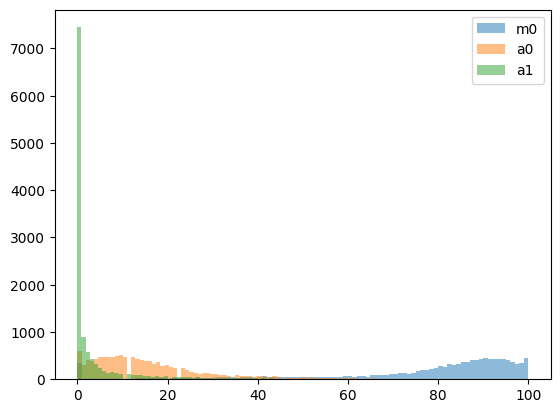

In [18]:
# Plot histograms of m0, a0 and a1 on same axes

import matplotlib.pyplot as plt
plt.hist(m0.cpu().numpy(), bins=100, alpha=0.5, label='m0')
plt.hist(a0.cpu().numpy(), bins=100, alpha=0.5, label='a0')
plt.hist(a1.cpu().numpy(), bins=100, alpha=0.5, label='a1')
plt.legend()
plt.show()

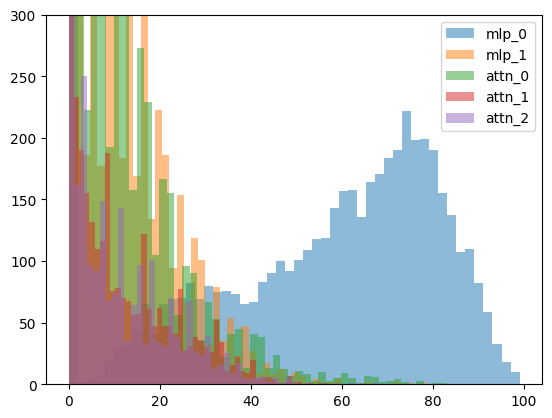

In [26]:
down_layer = 2
for up_layer in range(down_layer):
    up_name = f"mlp_{up_layer}"
    plt.hist((conn[f'mlp_{down_layer}'][up_name] > -1).float().sum(-1).cpu().numpy(), bins=50, alpha=0.5, label=up_name)

for up_layer in range(down_layer+1):
    up_name = f"attn_{up_layer}"
    plt.hist((conn[f'mlp_{down_layer}'][up_name] > -1).float().sum(-1).cpu().numpy(), bins=50, alpha=0.5, label=up_name)

plt.legend()
# set y range
plt.ylim(0, 300)
plt.show()

In [5]:
trainer_cfg = TrainerConfig(
    steps=1000,
    lr_decay_start_proportion=0.8,
    dead_feature_threshold=10_000_000,
    base_lr=2e-4,
    n_threshold=100,
    n_random=100,
)

In [6]:
trainer = TrainerSCAESuite(
    suite,
    config=trainer_cfg,
)

In [88]:
import gc
gc.collect()
t.cuda.empty_cache()

buffer.out_batch_size = 32
for _ in range(200):
    initial_acts, input_acts, target_acts, ln_scales = next(buffer)
    loss = trainer.update(
        500,
        initial_acts,
        input_acts,
        target_acts,
        ln_scales)
    print(loss)

27392.0
34560.0
26496.0
39936.0
35840.0
29952.0
27392.0
34560.0
27520.0
27904.0
28800.0
38400.0
30848.0
28288.0
25344.0
24192.0
26624.0
34816.0
37376.0
47104.0
36096.0
33024.0
57856.0
27008.0
28288.0
28800.0
36608.0
26368.0
29440.0
34560.0
26880.0
27264.0
27136.0
25216.0
28672.0
28544.0
33792.0
27392.0
27264.0
27136.0
36608.0
26240.0
28416.0
26880.0
26496.0
25984.0
32384.0
26112.0
26624.0
27264.0
26880.0
26368.0
26112.0
29952.0
26624.0
25728.0
26368.0
33024.0
25216.0
40704.0
25344.0
25600.0
25856.0
26368.0
25216.0
25472.0
34048.0
24960.0
26624.0
26112.0
28928.0
23808.0
27520.0
25856.0
23168.0
26624.0
27776.0
23040.0
23936.0
25216.0
26240.0
23040.0
25344.0
26880.0
25472.0
25600.0
33024.0
27648.0
27648.0
25344.0
23936.0
25088.0
41984.0
37888.0
35072.0
31104.0
30336.0
27136.0
33792.0
28672.0
24704.0
23168.0
24064.0
26112.0
31232.0
26368.0
23168.0
23552.0
33024.0
23168.0
23552.0
25088.0
24960.0
25984.0
24576.0
24960.0
32000.0
25856.0
23680.0
22400.0
30720.0
28416.0
25856.0
24320.0
31232.0


In [94]:
buffer.out_batch_size = 8
initial_acts, input_acts, target_acts, ln_scales = next(buffer)
initial_acts.shape

torch.Size([8, 768])

In [95]:
train_out = trainer.suite.pruned_forward_train(
    initial_acts,
    input_acts,
    ln_scales,
    n_random=0,
    n_threshold=0,
)

In [96]:
import gc
gc.collect()
t.cuda.empty_cache()
import gc
gc.collect()
t.cuda.empty_cache()

with t.no_grad():
    test_out = suite.pruned_forward_test(
    initial_acts,
    input_acts,
    ln_scales,
    return_topk=True
    )

In [97]:
for module in ["attn", "mlp"]:
    for layer in range(model.config.n_layer):
        
        test = test_out[0][f'{module}_{layer}']
        train = train_out[f'{module}_{layer}']['pruned_reconstruction']
        fvu = (test-train).pow(2).mean() / test.pow(2).mean()
        print(f"Layer {layer} FVU: {fvu.item()}")

Layer 0 FVU: 0.0
Layer 1 FVU: 0.0
Layer 2 FVU: 0.0
Layer 3 FVU: 0.0
Layer 4 FVU: 0.0
Layer 5 FVU: 0.0
Layer 6 FVU: 0.0
Layer 7 FVU: 0.0
Layer 8 FVU: 0.0
Layer 9 FVU: 0.0
Layer 10 FVU: 0.0
Layer 11 FVU: 0.0
Layer 0 FVU: 0.361328125
Layer 1 FVU: 2.71875
Layer 2 FVU: 1.2578125
Layer 3 FVU: 3.0
Layer 4 FVU: 3.265625
Layer 5 FVU: 1.5
Layer 6 FVU: 1.6484375
Layer 7 FVU: 1.078125
Layer 8 FVU: 0.6796875
Layer 9 FVU: 0.56640625
Layer 10 FVU: 0.4375
Layer 11 FVU: 1.1875


In [80]:
for module in ["attn", "mlp"]:
    for layer in range(model.config.n_layer):
        
        test = test_out[0][f'{module}_{layer}']
        train = train_out[f'{module}_{layer}']['pruned_reconstruction']
        fvu = (test-train).pow(2).mean() / test.pow(2).mean()
        print(f"Layer {layer} FVU: {fvu.item()}")

Layer 0 FVU: 0.0
Layer 1 FVU: 0.0
Layer 2 FVU: 0.0
Layer 3 FVU: 0.0
Layer 4 FVU: 0.0
Layer 5 FVU: 0.0
Layer 6 FVU: 0.0
Layer 7 FVU: 0.0
Layer 8 FVU: 0.0
Layer 9 FVU: 0.0
Layer 10 FVU: 0.0
Layer 11 FVU: 0.0
Layer 0 FVU: 0.2392578125
Layer 1 FVU: 2.78125
Layer 2 FVU: 1.0390625
Layer 3 FVU: 1.6953125
Layer 4 FVU: 2.5625
Layer 5 FVU: 1.65625
Layer 6 FVU: 1.75
Layer 7 FVU: 1.3515625
Layer 8 FVU: 0.8515625
Layer 9 FVU: 0.609375
Layer 10 FVU: 0.50390625
Layer 11 FVU: 2.640625


In [98]:
for module in ["mlp"]:
    for layer in range(model.config.n_layer):
        test = test_out[1][f'{module}_{layer}']['values']
        train = train_out[f'{module}_{layer}']['topk']
        fvu = (test-train).pow(2).mean() / test.pow(2).mean()
        print(f"Layer {layer} FVU: {fvu.item()}")

Layer 0 FVU: 0.2734375
Layer 1 FVU: 0.365234375
Layer 2 FVU: 0.486328125
Layer 3 FVU: 0.8046875
Layer 4 FVU: 0.9296875
Layer 5 FVU: 0.482421875
Layer 6 FVU: 0.2890625
Layer 7 FVU: 0.41015625
Layer 8 FVU: 0.81640625
Layer 9 FVU: 0.796875
Layer 10 FVU: 0.7109375
Layer 11 FVU: 0.78125


In [93]:
for module in ["mlp"]:
    for layer in range(model.config.n_layer):
        test = test_out[1][f'{module}_{layer}']['values']
        train = train_out[f'{module}_{layer}']['topk']
        fvu = (test-train).pow(2).mean() / test.pow(2).mean()
        print(f"Layer {layer} FVU: {fvu.item()}")

Layer 0 FVU: 0.1416015625
Layer 1 FVU: 0.2890625
Layer 2 FVU: 0.515625
Layer 3 FVU: 0.69921875
Layer 4 FVU: 0.83984375
Layer 5 FVU: 0.53125
Layer 6 FVU: 0.310546875
Layer 7 FVU: 0.462890625
Layer 8 FVU: 0.8515625
Layer 9 FVU: 1.0546875
Layer 10 FVU: 0.6796875
Layer 11 FVU: 0.63671875
